## Imports + data_prep

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
from PIL import Image

#keras imports
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import tensorflow.keras.preprocessing as preprocessing
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
from src import data_prep

In [3]:
df = data_prep()
df.sample(10)

,filename,label
9712,cat.2580.jpg,cat
4973,dog.10769.jpg,dog
10125,dog.90.jpg,dog
2385,dog.818.jpg,dog
24899,dog.11655.jpg,dog
16783,dog.9766.jpg,dog
1221,cat.11931.jpg,cat
13999,cat.11556.jpg,cat
17422,cat.7419.jpg,cat
21621,dog.5714.jpg,dog


## Modeling

### revised EDA

I messed up the code I used to get the average image size by including the width and height lists within the for loop, resetting them each time and only using the last image's dimensions. 

In [7]:
width = []#these guys should have been here
height = [] 
data_path = '../Data/train'    
filenames = os.listdir(data_path)

for filename in filenames:
    
    img_path = os.path.join(data_path, filename)
    im = Image.open(img_path)
    
    w, h = im.size
    
    width.append(w)
    height.append(h)
    
w_avg = sum(width)/len(width)
h_avg = sum(height)/len(height)
    
width = int(w_avg)
height = int(h_avg)
img_size = (width, height)

print(width, height)

404 360


In [13]:
batch_size = 32

In [9]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.0001)

call_backs = [earlystop, learning_rate_reduction]

In [11]:
X_t, v_t = train_test_split(df, test_size = 0.15,  random_state = 7)
X_t = X_t.reset_index(drop = True)
v_t = v_t.reset_index(drop=True)

In [14]:
img_gen = ImageDataGenerator(rescale = 1./255., horizontal_flip = True)

train_generator = img_gen.flow_from_dataframe(
    X_t,
    data_path,
    x_col = 'filename',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode ='categorical'
)

val_img_gen = ImageDataGenerator(rescale = 1./255.)

val_generator = img_gen.flow_from_dataframe(
    v_t,
    data_path,
    x_col = 'filename',
    y_col = 'label',
    target_size = img_size,
    batch_size = batch_size,
    class_mode ='categorical'
)



Found 21250 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.


In [15]:
alpha = Sequential() 
alpha.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (width, height, 3)))#3 for rgb
alpha.add(MaxPooling2D(pool_size=(2, 2)))
alpha.add(BatchNormalization())
alpha.add(Dropout(0.20))

alpha.add(Conv2D(64, (3, 3), activation = 'relu'))
alpha.add(MaxPooling2D((2, 2)))
alpha.add(BatchNormalization())
alpha.add(Dropout(0.20))

alpha.add(Conv2D(128, (3, 3), activation = 'relu'))
alpha.add(MaxPooling2D((2, 2)))
alpha.add(BatchNormalization())
alpha.add(Dropout(0.20))

alpha.add(Conv2D(256, (3, 3), activation = 'relu'))
alpha.add(MaxPooling2D((2, 2)))
alpha.add(BatchNormalization())
alpha.add(Dropout(0.20))

alpha.add(Flatten())
alpha.add(Dense(128, activation='relu'))
alpha.add(BatchNormalization())
alpha.add(Dropout(0.20))

alpha.add(Dense(256, activation='relu'))
alpha.add(BatchNormalization())
alpha.add(Dropout(0.20))

alpha.add(Dense(2, activation='softmax')) #2 for cat or dog
alpha.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

alpha.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 402, 358, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 201, 179, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 201, 179, 32)      128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 201, 179, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 199, 177, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 99, 88, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 99, 88, 64)        256       
__________

In [16]:
history_alpha = alpha.fit_generator(
    train_generator, 
    epochs = 50,
    validation_data = val_generator,
    validation_steps = 20,
    steps_per_epoch = 100,
    callbacks = call_backs  
)

W1107 13:52:00.691391 4607008192 deprecation.py:323] From /Users/adamroth/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
100/100 [==============================] - 1055s 11s/step - loss: 0.8922 - acc: 0.5544 - val_loss: 1.4248 - val_acc: 0.6141
Epoch 2/50
100/100 [==============================] - 998s 10s/step - loss: 0.7365 - acc: 0.6075 - val_loss: 1.0304 - val_acc: 0.5953
Epoch 3/50
100/100 [==============================] - 1034s 10s/step - loss: 0.7086 - acc: 0.6125 - val_loss: 0.7335 - val_acc: 0.5750

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/50
100/100 [==============================] - 1035s 10s/step - loss: 0.6407 - acc: 0.6572 - val_loss: 0.5989 - val_acc: 0.6719
Epoch 5/50
100/100 [==============================] - 1017s 10s/step - loss: 0.5963 - acc: 0.6900 - val_loss: 0.5931 - val_acc: 0.6609
Epoch 6/50
100/100 [==============================] - 1006s 10s/step - loss: 0.5912 - acc: 0.6950 - val_loss: 0.5782 - val_acc: 0.6938
Epoch 7/50
100/100 [==============================] - 978s 10s/step - loss: 0.5935 - acc: 0.6937 - val_loss: 0

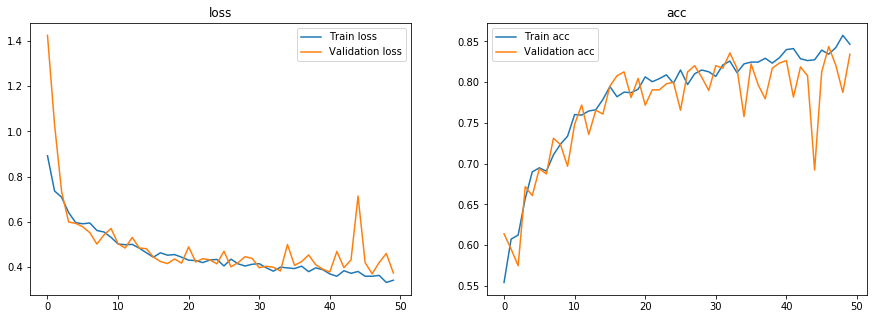

In [19]:
vis_history(history_alpha)

In [18]:
def vis_history(history): 
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

Looks like it can go even longer, so I'll run even more epochs in the next model, beta. I do not plan on making any more changes to the model framework itself untill the callback shuts it down before the epochs are done.

In [20]:
beta = Sequential() 
beta.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (width, height, 3)))#3 for rgb
beta.add(MaxPooling2D(pool_size=(2, 2)))
beta.add(BatchNormalization())
beta.add(Dropout(0.20))

beta.add(Conv2D(64, (3, 3), activation = 'relu'))
beta.add(MaxPooling2D((2, 2)))
beta.add(BatchNormalization())
beta.add(Dropout(0.20))

beta.add(Conv2D(128, (3, 3), activation = 'relu'))
beta.add(MaxPooling2D((2, 2)))
beta.add(BatchNormalization())
beta.add(Dropout(0.20))

beta.add(Conv2D(256, (3, 3), activation = 'relu'))
beta.add(MaxPooling2D((2, 2)))
beta.add(BatchNormalization())
beta.add(Dropout(0.20))

beta.add(Flatten())
beta.add(Dense(128, activation='relu'))
beta.add(BatchNormalization())
beta.add(Dropout(0.20))

beta.add(Dense(256, activation='relu'))
beta.add(BatchNormalization())
beta.add(Dropout(0.20))

beta.add(Dense(2, activation='softmax')) #2 for cat or dog
beta.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

beta.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 402, 358, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 201, 179, 32)      0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 201, 179, 32)      128       
_________________________________________________________________
dropout_13 (Dropout)         (None, 201, 179, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 199, 177, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 99, 88, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 99, 88, 64)        256       
__________

In [21]:
history_beta = beta.fit_generator(
    train_generator, 
    epochs = 100,
    validation_data = val_generator,
    validation_steps = 20,
    steps_per_epoch = 100,
    callbacks = call_backs  
)

Epoch 1/100
100/100 [==============================] - 1034s 10s/step - loss: 0.8717 - acc: 0.5669 - val_loss: 0.6969 - val_acc: 0.5891
Epoch 2/100
100/100 [==============================] - 1017s 10s/step - loss: 0.7376 - acc: 0.6012 - val_loss: 1.4339 - val_acc: 0.6047
Epoch 3/100
100/100 [==============================] - 995s 10s/step - loss: 0.6877 - acc: 0.6128 - val_loss: 1.5565 - val_acc: 0.5130
Epoch 4/100
100/100 [==============================] - 990s 10s/step - loss: 0.6553 - acc: 0.6391 - val_loss: 0.7426 - val_acc: 0.5766

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/100
100/100 [==============================] - 997s 10s/step - loss: 0.6238 - acc: 0.6531 - val_loss: 0.6617 - val_acc: 0.6312
Epoch 6/100
100/100 [==============================] - 1012s 10s/step - loss: 0.5668 - acc: 0.7053 - val_loss: 0.5383 - val_acc: 0.7094
Epoch 7/100
100/100 [==============================] - 1002s 10s/step - loss: 0.5536 - acc: 0.7197 - val_l

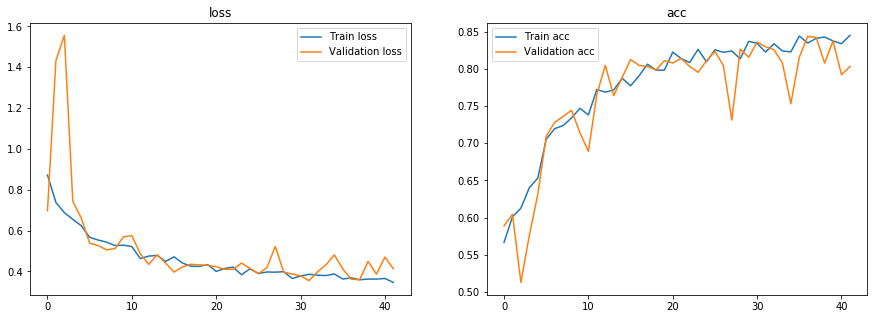

In [22]:
vis_history(history_beta)

In [25]:
beta.save('../models/beta')

In [26]:
alpha.save('../models/alpha')

I want to do one more of these, so far alpha and beta are mostly equally good, with alpha performing a tiny bit better (their layers are identical so...). I'm gonna mix it up a little bit with the next one by adding some more complexity to all the layers (x2) and upping the dropout in the final layer. After that I will try resizing the images to a uniform shape and running that with identical code to either alpha/beta or charlie, whichever one 'wins' here. 

In [27]:
charlie = Sequential() 
charlie.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (width, height, 3)))#3 for rgb
charlie.add(MaxPooling2D(pool_size=(2, 2)))
charlie.add(BatchNormalization())
charlie.add(Dropout(0.20))

charlie.add(Conv2D(128, (3, 3), activation = 'relu'))
charlie.add(MaxPooling2D((2, 2)))
charlie.add(BatchNormalization())
charlie.add(Dropout(0.20))

charlie.add(Conv2D(256, (3, 3), activation = 'relu'))
charlie.add(MaxPooling2D((2, 2)))
charlie.add(BatchNormalization())
charlie.add(Dropout(0.20))

charlie.add(Conv2D(512, (3, 3), activation = 'relu'))
charlie.add(MaxPooling2D((2, 2)))
charlie.add(BatchNormalization())
charlie.add(Dropout(0.20))

charlie.add(Flatten())
charlie.add(Dense(256, activation='relu'))
charlie.add(BatchNormalization())
charlie.add(Dropout(0.20))

charlie.add(Dense(512, activation='relu'))
charlie.add(BatchNormalization())
charlie.add(Dropout(0.50))

charlie.add(Dense(2, activation='softmax')) #2 for cat or dog
charlie.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

charlie.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 402, 358, 64)      1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 201, 179, 64)      0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 201, 179, 64)      256       
_________________________________________________________________
dropout_19 (Dropout)         (None, 201, 179, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 199, 177, 128)     73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 99, 88, 128)       0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 99, 88, 128)       512       
__________

In [28]:
history_charlie = charlie.fit_generator(
    train_generator, 
    epochs = 50, #100 was excessive
    validation_data = val_generator,
    validation_steps = 20,
    steps_per_epoch = 100,
    callbacks = call_backs  
)

Epoch 1/50
100/100 [==============================] - 3554s 36s/step - loss: 1.1676 - acc: 0.5163 - val_loss: 4.0715 - val_acc: 0.5125
Epoch 2/50
100/100 [==============================] - 3358s 34s/step - loss: 0.9021 - acc: 0.5647 - val_loss: 1.3315 - val_acc: 0.5863
Epoch 3/50
100/100 [==============================] - 3409s 34s/step - loss: 0.7660 - acc: 0.5994 - val_loss: 1.1537 - val_acc: 0.6094
Epoch 4/50
100/100 [==============================] - 3262s 33s/step - loss: 0.6919 - acc: 0.6125 - val_loss: 1.0846 - val_acc: 0.6125
Epoch 5/50
100/100 [==============================] - 3284s 33s/step - loss: 0.6618 - acc: 0.6291 - val_loss: 0.7965 - val_acc: 0.6328
Epoch 6/50
100/100 [==============================] - 3376s 34s/step - loss: 0.6163 - acc: 0.6672 - val_loss: 0.6179 - val_acc: 0.6891
Epoch 7/50
100/100 [==============================] - 3394s 34s/step - loss: 0.5871 - acc: 0.6825 - val_loss: 0.6734 - val_acc: 0.6141
Epoch 8/50
100/100 [==============================] - 3

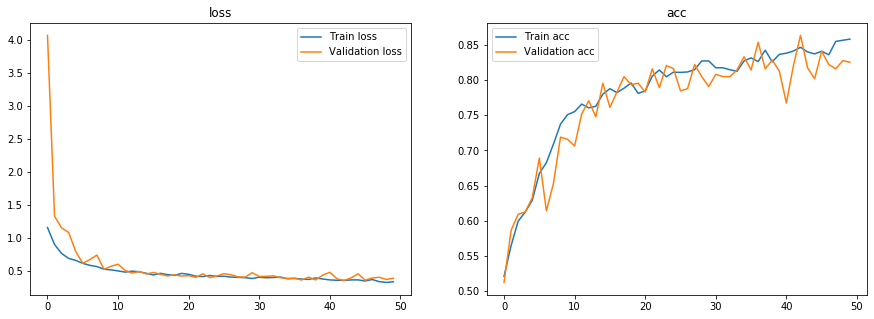

In [30]:
vis_history(history_charlie)

### Retype later!!! 

charlies did about as well as alpha but took like a day and a half to train, so not worth, gonna try new target size of 256x256 and use grayscale rather than rgb as cats and dogs can be diff colors, so color might not help 